# ecMINN

In [ ]:
import numpy as np
from sklearn.model_selection import LeaveOneOut
import pandas as pd
from src.nn_model.amn_qp import *
from src.utils.hpo import hpo
from src.utils.import_data import *
from src.utils.import_GEM import *
from src.utils.training import *
from src.utils.plots import *
from src.utils.utils import *
from hydra import initialize, compose
from omegaconf import OmegaConf
import logging

# hydra in jupyter notebook
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

config_dir = "conf" # Adjust pat#h
initialize(config_path=config_dir, job_name="notebook_logging", version_base="1.1")


cfg = compose(config_name="MINN_c_scheduler_pec")

# Step 3: Log the configuration
logger.info("Logging configuration:")
logger.info(OmegaConf.to_yaml(cfg))

# No clearML when using jupyter
task= None
# reproduciblility
seed = cfg.seed
fix_random_seed(seed=seed)

# load gem and data
n_distribution= cfg.gem.n_total_reactions
X, y, Vin, fit_model, reference = load_ishii(seed=seed, 
                                                dataset=cfg.dataset.dataset_name,
                                                fluxes_removed_from_reference=cfg.dataset.fluxes_removed_from_reference,
                                                fluxes_to_add_input = cfg.dataset.fluxes_to_add_input,
                                                kos_genes= cfg.dataset.kos_genes,
                                                gem = cfg.gem.gem_name)
print("X: \n", X[0])
print("X len: \n", len(X[0]))


# Leave-One-Out Cross-Validation
loo = LeaveOneOut()
from joblib import Parallel, delayed

Q2_loo, MAE_loo, RMSE_loo, NE_loo = [], [], [], []
Vref_true_loo, Vref_pred_loo, Vpred_final = [], [], []
list_SV_loss_per_sample = []

total_run= 29
count = 1
for train_idx, val_idx in loo.split(X):
    # Extract the training and validation data
    X_train, y_train, Vin_train = X[train_idx], y[train_idx], Vin[train_idx]
    X_val, y_val, Vin_val = X[val_idx], y[val_idx], Vin[val_idx]

    # kfolf cross validation 
    best_params = hpo(cfg, task=task, X_train=X_train, y_train=y_train, Vin_train=Vin_train, n_distribution=n_distribution, fit_model=fit_model)
    #best_params = {'hidden_size': 200, 'drop_rate': 0.5, 'learning_rate': 0.0002, 'weight_decay': 0.001, 'l1_constant': 50}
    print("<<<<<< BEST_PARAMS >>>>>> \n", best_params)
    # train and test using the best hyperparameters found with the kfold
    results = train_test_evaluation(cfg, task, X_train, X_val, y_train, y_val, Vin_train, Vin_val, n_distribution, fit_model, best_params, loo_count=count)
    

    # Inverse transform targets to extract metrics
    Vref_pred_te = np.matmul(np.array(results["test"]['Vref_pred']), fit_model.Pref.T)
    Vref_true = results["test"]['Vref_true']
    
    
    # save metrics in the a list (one for each left out observation)
    Q2_value = r2_metric(np.array(Vref_true), Vref_pred_te)
    Q2_loo.append(Q2_value)

    MAE_value = np.mean(np.abs(Vref_true-Vref_pred_te))
    MAE_loo.append(MAE_value)

    RMSE_value = np.sqrt(np.mean(np.square(Vref_true-Vref_pred_te)))
    RMSE_loo.append(RMSE_value)

    NE_value = np.nan_to_num(np.linalg.norm(Vref_true - Vref_pred_te) / np.linalg.norm(Vref_true), posinf=0, neginf=0, nan=0)
    NE_loo.append(NE_value)

    Vref_true_loo.append(np.array(Vref_true).flatten())
    Vref_pred_loo.append(np.array(Vref_pred_te).flatten())
    Vpred_final.append(np.array(results["test"]['Vref_pred']).flatten())
    

    print(f'run {count}/{total_run}')
    print(f'Loss Train: {results["train"]["losses"]}')
    print(f'Loss Test: {results["test"]["losses"]}')
    print(f'Q²:{Q2_value}')
    print(f'MAE:{MAE_value}')
    print(f'RMSE {RMSE_value}')
    print(f'NE:{NE_value}')
    
    list_SV_loss_per_sample.append(results["test"]["losses"][1])
    count += 1

Namespace(Qp_iteration=8, prior_knowledge=False, exp_name='test', L1='MSE', model='AMN', device='cuda:0')
pyparsing import
CBGLPK based on swiglpk: not all methods implimented yet! 5.0



No module named 'cplex'



CPLEX not available

*****
Using GLPK
*****

doFBAMinSum not available with GLPK


***********************************************************************
* Welcome to CBMPy (0.8.8) - PySCeS Constraint Based Modelling        *
*       https://systemsbioinformatics.github.io/cbmpy/                *
* Copyright (C) Brett G. Olivier, 2014 - 2024                         *
* Systems Biology Lab, A-LIFE, AIMMS, Faculty of Science              *
* Vrije Universiteit Amsterdam, Amsterdam, The Netherlands            *
* This version of CBMPy distributed under the GNU GPL v 3.0 licence   *
***********************************************************************



INFO:__main__:Logging configuration:
INFO:__main__:dataset:
  dataset_name: ref_fluxes_pec_iAF1260
  fluxes_removed_from_reference:
  - R_usage_prot_P0A9C3
  - R_usage_prot_P36938
  - R_usage_prot_P0A6T1
  - R_usage_prot_P06999
  - R_usage_prot_P0A993
  - R_usage_prot_P0AB71
  - R_usage_prot_P0A858
  - R_usage_prot_P0A9B2
  - R_usage_prot_P0A799
  - R_usage_prot_P62707
  - R_usage_prot_P0A6P9
  - R_usage_prot_P21599
  - R_usage_prot_P0AD61
  - R_usage_prot_P23538
  - R_usage_prot_P0AC53
  - R_usage_prot_P52697
  - R_usage_prot_P00350
  - R_usage_prot_P0AG07
  - R_usage_prot_P0A7Z0
  - R_usage_prot_P27302
  - R_usage_prot_P33570
  - R_usage_prot_P0A867
  - R_usage_prot_P0A870
  - R_usage_prot_P0A955
  - R_usage_prot_P0AFG8
  - R_usage_prot_P06959
  - R_usage_prot_P0A9P0
  - R_usage_prot_P22259
  - R_usage_prot_P00864
  - R_usage_prot_P0ABH7
  - R_usage_prot_P36683
  - R_usage_prot_P0AFG6
  - R_usage_prot_P0A836
  - R_usage_prot_P0AGE9
  - R_usage_prot_P0AC41
  - R_usage_prot_P07014
  - 

Attempting to load SBML file: GEMs/iAF1260_ec_duplicated.xml
SBML Level 3 FBC version 2 model detected, loading with cbmpy.readSBML3FBC()
FBC version: 2
M.getNumReactions: 6542
M.getNumSpecies: 2929
FBC.getNumObjectives: 1
FBC.getNumParameters: 6541
FBC.getNumGeneProducts: 1262
Zero dimension compartment detected: c
Zero dimension compartment detected: p
Zero dimension compartment detected: e
FluxBounds process1: 0.123
INFO: Active objective: obj
Adding objective: obj
FluxBounds process2: 0.599
Gene G_standard is not part of a GPR association. Will create anyway!

User defined contraint FBC version 2
SBML3 load time: 5.66

reference: Index(['R_usage_prot_P0A6V8', 'R_usage_prot_P0A796', 'R_usage_prot_P37351',
       'R_usage_prot_P0ADF6', 'R_usage_prot_P25516', 'R_usage_prot_P0AFG3',
       'R_usage_prot_P07003', 'R_usage_prot_P32675', 'R_GLCptspp_for_2',
       'R_PGI_for', 'R_PFK_for_2', 'R_FBA_for', 'R_TPI_for', 'R_PGK_rev',
       'R_ENO_for', 'R_PYK_for_2', 'R_PDH', 'R_PGL', 'R_GND

[I 2025-10-01 10:34:17,731] A new study created in RDB with name: no-name-e5edb637-ee6d-411c-88d0-f200f7d034f5
[I 2025-10-01 10:42:14,708] Trial 0 finished with value: 1.0293354912598927 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.0293354912598927.
[I 2025-10-01 10:48:57,197] Trial 1 finished with value: 1.1709466387828191 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.0293354912598927.
[I 2025-10-01 10:59:26,737] Trial 2 finished with value: 0.8530653436978659 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 0.8530653436978659.
[I 2025-10-01 11:05:43,552] Trial 3 finished with value: 1.1076001904408137 and parameters: {'depth': 5, 'hidd

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-01 11:59:05,776] A new study created in RDB with name: no-name-0df23cf5-8c70-4dee-a807-903f9e15dcd8


run 1/29
Loss Train: [4.23363979e-01 1.66251699e-02 2.24835527e-02 8.01781490e-12]
Loss Test: [1.45054884e+01 1.77994315e-02 1.84187070e-01 3.04302833e-15]
Q²:[0.71615332]
MAE:2.3307950067297276
RMSE 3.6811644704479285
NE:0.5154166678668791


[I 2025-10-01 12:05:35,266] Trial 0 finished with value: 2.012695748209953 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 2.012695748209953.
[I 2025-10-01 12:11:42,026] Trial 1 finished with value: 2.2787296851476038 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 2.012695748209953.
[I 2025-10-01 12:21:59,474] Trial 2 finished with value: 1.235112331708272 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.235112331708272.
[I 2025-10-01 12:28:09,119] Trial 3 finished with value: 2.3283873695135116 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-01 13:20:05,467] A new study created in RDB with name: no-name-525eb913-413e-4e08-96cc-9c532f85664e


run 2/29
Loss Train: [1.08929103e+00 1.29769816e-02 3.89427456e-02 5.53625385e-12]
Loss Test: [1.39665556e+00 4.12214594e-03 5.23996837e-02 6.68705746e-14]
Q²:[0.83250092]
MAE:0.702292273627697
RMSE 1.1711398521060827
NE:0.4121416490629227


[I 2025-10-01 13:27:08,161] Trial 0 finished with value: 2.0392784053087234 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 2.0392784053087234.
[I 2025-10-01 13:32:57,605] Trial 1 finished with value: 2.3954145761330925 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 2.0392784053087234.
[I 2025-10-01 13:43:20,476] Trial 2 finished with value: 1.3056254084904988 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.3056254084904988.
[I 2025-10-01 13:49:14,732] Trial 3 finished with value: 2.4111019372940063 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is tr

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-01 14:40:06,309] A new study created in RDB with name: no-name-a7007303-c7f9-4cc8-929a-eef817a659c2


run 3/29
Loss Train: [7.87023221e-01 1.68870590e-02 6.18673411e-02 6.35810622e-12]
Loss Test: [4.01076078e-01 4.06587645e-02 2.36300798e-03 1.76908748e-11]
Q²:[0.95082878]
MAE:0.430592674905359
RMSE 0.6332977593523301
NE:0.3048256063084926


[I 2025-10-01 14:47:04,612] Trial 0 finished with value: 1.9821355974674222 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9821355974674222.
[I 2025-10-01 14:53:05,272] Trial 1 finished with value: 2.3077472825845082 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9821355974674222.
[I 2025-10-01 15:03:26,840] Trial 2 finished with value: 1.282746880054474 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.282746880054474.
[I 2025-10-01 15:09:28,258] Trial 3 finished with value: 2.3476594952742262 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is tria

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-01 15:58:43,348] A new study created in RDB with name: no-name-82f64a05-84ba-467e-a5aa-7ade16d11559


run 4/29
Loss Train: [7.80060323e-01 1.57967375e-02 5.76323960e-02 4.85131604e-12]
Loss Test: [3.27633172e-01 3.93464230e-03 2.05233574e-01 4.19416238e-13]
Q²:[0.96964021]
MAE:0.24510550636983908
RMSE 0.5707834270519311
NE:0.286104133954689


[I 2025-10-01 16:05:01,562] Trial 0 finished with value: 1.9723861102263132 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9723861102263132.
[I 2025-10-01 16:10:33,631] Trial 1 finished with value: 2.3207772509256994 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9723861102263132.
[I 2025-10-01 16:20:34,478] Trial 2 finished with value: 1.3274510763088863 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.3274510763088863.
[I 2025-10-01 16:26:39,546] Trial 3 finished with value: 2.3395315551757814 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is tr

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-01 17:16:46,862] A new study created in RDB with name: no-name-4944ed50-d540-4ee9-a935-b6b91bc4e471


run 5/29
Loss Train: [6.86101045e-01 1.44367823e-02 4.76673470e-02 5.78431115e-12]
Loss Test: [5.16068637e-01 1.80857144e-02 5.00414483e-02 6.63323476e-12]
Q²:[0.79294115]
MAE:0.42062935684926
RMSE 0.674017013364865
NE:0.4843181624262176


[I 2025-10-01 17:23:12,396] Trial 0 finished with value: 1.9573038289944331 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9573038289944331.
[I 2025-10-01 17:28:49,595] Trial 1 finished with value: 2.353817437092463 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9573038289944331.
[I 2025-10-01 17:38:47,979] Trial 2 finished with value: 1.2963747402032215 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.2963747402032215.
[I 2025-10-01 17:44:36,073] Trial 3 finished with value: 2.3592863488197326 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is tri

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-01 18:33:40,866] A new study created in RDB with name: no-name-ae7232e4-f759-4ec1-87b8-f666b03096cf


run 6/29
Loss Train: [7.33662673e-01 1.65245666e-02 4.99621306e-02 6.04951394e-12]
Loss Test: [3.66607875e-01 3.71881947e-03 1.56004801e-02 7.89516130e-13]
Q²:[0.94901135]
MAE:0.38125300841194126
RMSE 0.5783307228942091
NE:0.27905388559887934


[I 2025-10-01 18:39:44,699] Trial 0 finished with value: 1.9852956324815754 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9852956324815754.
[I 2025-10-01 18:45:29,765] Trial 1 finished with value: 2.3707519191503525 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9852956324815754.
[I 2025-10-01 18:55:45,501] Trial 2 finished with value: 1.2710151911775271 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.2710151911775271.
[I 2025-10-01 19:01:27,899] Trial 3 finished with value: 2.3631690887610115 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is tr

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-01 19:50:20,922] A new study created in RDB with name: no-name-9abc42dc-5670-4fcb-9e43-99fb158aa8de


run 7/29
Loss Train: [6.81094191e-01 1.80683453e-02 4.30428681e-02 7.55947695e-12]
Loss Test: [5.30556552e-02 2.46262178e-02 1.77852705e-03 1.05894096e-11]
Q²:[0.97649103]
MAE:0.16902058510596873
RMSE 0.22367270075602022
NE:0.12760994577304635


[I 2025-10-01 19:56:31,192] Trial 0 finished with value: 1.9433360622326532 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9433360622326532.
[I 2025-10-01 20:02:26,485] Trial 1 finished with value: 2.361568231980006 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9433360622326532.
[I 2025-10-01 20:12:28,037] Trial 2 finished with value: 1.2228238819042843 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.2228238819042843.
[I 2025-10-01 20:18:11,330] Trial 3 finished with value: 2.3445386266708375 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is tri

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-01 21:06:45,338] A new study created in RDB with name: no-name-5ac70630-cb9a-4e65-be56-ebf1c2e88e7c


run 8/29
Loss Train: [1.20580641e+00 1.35585298e-02 5.01901350e-02 3.42793570e-12]
Loss Test: [2.47639164e-01 3.13468389e-02 3.18906317e-03 1.09885425e-11]
Q²:[0.98095823]
MAE:0.2348670474873288
RMSE 0.30044171200788045
NE:0.16768119230171882


[I 2025-10-01 21:13:03,369] Trial 0 finished with value: 1.9811315574248636 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9811315574248636.
[I 2025-10-01 21:18:52,259] Trial 1 finished with value: 2.3102984933058424 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9811315574248636.
[I 2025-10-01 21:28:52,356] Trial 2 finished with value: 1.2475670878092449 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.2475670878092449.
[I 2025-10-01 21:34:50,137] Trial 3 finished with value: 2.357729497551918 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is tri

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-01 22:23:58,338] A new study created in RDB with name: no-name-1683aa2f-8718-446b-b28a-36dd08d1b6fd


run 9/29
Loss Train: [1.09146685e+00 1.41383870e-02 5.28577561e-02 4.76718494e-12]
Loss Test: [1.56637356e-01 6.68572402e-03 1.49245118e-03 1.48735278e-12]
Q²:[0.98072619]
MAE:0.18778088353074787
RMSE 0.2757844702276972
NE:0.14309116706491


[I 2025-10-01 22:30:21,457] Trial 0 finished with value: 1.943402412732442 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.943402412732442.
[I 2025-10-01 22:36:22,701] Trial 1 finished with value: 2.369538683493932 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.943402412732442.
[I 2025-10-01 22:46:36,837] Trial 2 finished with value: 1.2962649846076966 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.2962649846076966.
[I 2025-10-01 22:52:42,206] Trial 3 finished with value: 2.332399227619171 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-01 23:42:22,688] A new study created in RDB with name: no-name-f1d659f0-32fa-418d-a62f-fafd94401176


run 10/29
Loss Train: [9.73019195e-01 1.58966679e-02 5.09290152e-02 6.29658968e-12]
Loss Test: [7.16682225e-02 1.29885608e-02 1.12338015e-03 4.02127767e-12]
Q²:[0.98509625]
MAE:0.13918830200345647
RMSE 0.1965843796168318
NE:0.09982876650357594


[I 2025-10-01 23:48:45,272] Trial 0 finished with value: 1.9647385132312774 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9647385132312774.
[I 2025-10-01 23:54:42,008] Trial 1 finished with value: 2.3174665131171546 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9647385132312774.
[I 2025-10-02 00:05:02,003] Trial 2 finished with value: 1.3216380043824512 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.3216380043824512.
[I 2025-10-02 00:10:59,531] Trial 3 finished with value: 2.388516850074132 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is tri

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-02 01:00:29,598] A new study created in RDB with name: no-name-26e8c2c7-ff03-4319-b0bf-3f9d46d4c9a9


run 11/29
Loss Train: [7.19522634e-01 1.44754469e-02 5.02856706e-02 4.47287899e-12]
Loss Test: [3.18077914e-02 1.60420816e-02 3.99808079e-04 4.70941732e-12]
Q²:[0.9902768]
MAE:0.14010316160593042
RMSE 0.17072081162779298
NE:0.09457398258138378


[I 2025-10-02 01:06:53,879] Trial 0 finished with value: 2.000571183562279 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 2.000571183562279.
[I 2025-10-02 01:12:48,214] Trial 1 finished with value: 2.312469057838122 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 2.000571183562279.
[I 2025-10-02 01:23:03,177] Trial 2 finished with value: 1.281807341972987 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.281807341972987.
[I 2025-10-02 01:29:09,369] Trial 3 finished with value: 2.3828937737147013 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-02 02:19:04,782] A new study created in RDB with name: no-name-3ef71289-2b57-4e46-90c8-49229b60d018


run 12/29
Loss Train: [7.13608133e-01 1.46828320e-02 6.29438805e-02 5.97697853e-12]
Loss Test: [3.48835737e-01 9.91025753e-03 5.86370863e-02 3.56054097e-12]
Q²:[0.9199952]
MAE:0.3558595438699683
RMSE 0.5474555528227661
NE:0.2471213416642111


[I 2025-10-02 02:25:30,461] Trial 0 finished with value: 1.9255181000630064 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9255181000630064.
[I 2025-10-02 02:31:26,179] Trial 1 finished with value: 2.3938674330711365 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9255181000630064.
[I 2025-10-02 02:41:42,627] Trial 2 finished with value: 1.3061389082670214 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.3061389082670214.
[I 2025-10-02 02:47:28,108] Trial 3 finished with value: 2.3883184868097307 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is tr

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-02 03:36:59,459] A new study created in RDB with name: no-name-05b92cc2-37e5-44ef-841d-d5bf1f9e390c


run 13/29
Loss Train: [9.21587752e-01 1.62145457e-02 4.79738883e-02 5.00584491e-12]
Loss Test: [3.15061003e-01 1.43560888e-02 7.00439443e-04 3.55952832e-12]
Q²:[0.99228013]
MAE:0.11045518808145897
RMSE 0.1617908737730814
NE:0.08493782193238436


[I 2025-10-02 03:43:19,446] Trial 0 finished with value: 1.9244266192118324 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9244266192118324.
[I 2025-10-02 03:49:05,845] Trial 1 finished with value: 2.337856892347336 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9244266192118324.
[I 2025-10-02 03:59:27,742] Trial 2 finished with value: 1.3738134109973907 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.3738134109973907.
[I 2025-10-02 04:05:40,421] Trial 3 finished with value: 2.4345422911643984 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is tri

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-02 04:55:06,078] A new study created in RDB with name: no-name-4be710f2-813d-489d-821a-fdbdc3183a94


run 14/29
Loss Train: [8.82890186e-01 1.33626078e-02 5.17220848e-02 4.01207113e-12]
Loss Test: [9.69454572e-02 1.26133841e-02 6.15781499e-03 3.11997086e-12]
Q²:[0.96613405]
MAE:0.20022393709462602
RMSE 0.2866223842017507
NE:0.16526986049262135


[I 2025-10-02 05:01:57,442] Trial 0 finished with value: 2.062704883615176 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 2.062704883615176.
[I 2025-10-02 05:08:01,391] Trial 1 finished with value: 2.36766795873642 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 2.062704883615176.
[I 2025-10-02 05:18:05,747] Trial 2 finished with value: 1.3180036667982737 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.3180036667982737.
[I 2025-10-02 05:24:20,847] Trial 3 finished with value: 2.3209644623597465 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-02 06:16:31,353] A new study created in RDB with name: no-name-4a81a8ca-b21b-410d-a059-b2366bda6d8c


run 15/29
Loss Train: [7.46154355e-01 1.48067220e-02 3.56515775e-02 5.09618600e-12]
Loss Test: [1.53804779e-01 5.35047753e-03 7.38946837e-04 1.25638161e-12]
Q²:[0.96040419]
MAE:0.20087964433319883
RMSE 0.3780430677689166
NE:0.17009301178892405


[I 2025-10-02 06:23:17,926] Trial 0 finished with value: 2.0326224408547082 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 2.0326224408547082.
[I 2025-10-02 06:29:27,630] Trial 1 finished with value: 2.4000394332408908 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 2.0326224408547082.
[I 2025-10-02 06:40:20,345] Trial 2 finished with value: 1.3188024667898817 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.3188024667898817.
[I 2025-10-02 06:46:43,545] Trial 3 finished with value: 2.385490493575732 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is tri

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-02 07:39:25,670] A new study created in RDB with name: no-name-93fa0d57-52b5-47fe-b9a7-a181d3599f13


run 16/29
Loss Train: [8.44578040e-01 1.51417345e-02 5.28955003e-02 5.15851800e-12]
Loss Test: [1.36366978e-01 4.03922703e-03 1.38265907e-03 6.57144586e-13]
Q²:[0.98135666]
MAE:0.18811315724283992
RMSE 0.27370948370111403
NE:0.11377598230949346


[I 2025-10-02 07:45:53,181] Trial 0 finished with value: 2.0036537992954253 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 2.0036537992954253.
[I 2025-10-02 07:51:50,813] Trial 1 finished with value: 2.3341558396816255 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 2.0036537992954253.
[I 2025-10-02 08:02:09,030] Trial 2 finished with value: 1.3373071029782295 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.3373071029782295.
[I 2025-10-02 08:08:06,093] Trial 3 finished with value: 2.351579117178917 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is tri

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-02 08:56:52,661] A new study created in RDB with name: no-name-2661e9e7-5735-45b3-8c63-0faac6b6c960


run 17/29
Loss Train: [6.68333667e-01 1.64811748e-02 5.31688685e-02 7.02353339e-12]
Loss Test: [1.86494455e-01 3.91059509e-03 2.10262067e-03 4.03169848e-13]
Q²:[0.96248855]
MAE:0.20058530156915444
RMSE 0.43011614644339574
NE:0.165514680506067


[I 2025-10-02 09:03:22,675] Trial 0 finished with value: 1.949112543066343 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.949112543066343.
[I 2025-10-02 09:09:29,707] Trial 1 finished with value: 2.290193667411804 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.949112543066343.
[I 2025-10-02 09:19:54,511] Trial 2 finished with value: 1.241779113014539 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.241779113014539.
[I 2025-10-02 09:25:39,278] Trial 3 finished with value: 2.4123215119043984 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-02 10:15:14,956] A new study created in RDB with name: no-name-dafd0041-c87a-4e9f-87a0-c6cb247546ba


run 18/29
Loss Train: [7.13073420e-01 1.62180158e-02 6.15285725e-02 6.59246420e-12]
Loss Test: [2.14103684e-01 1.80139001e-02 1.97673053e-03 6.73459118e-12]
Q²:[0.95701136]
MAE:0.3179333266141546
RMSE 0.4612730968031678
NE:0.22018103122893168


[I 2025-10-02 10:21:42,341] Trial 0 finished with value: 1.8863599389791488 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.8863599389791488.
[I 2025-10-02 10:27:42,872] Trial 1 finished with value: 2.2374491769075395 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.8863599389791488.
[I 2025-10-02 10:38:06,936] Trial 2 finished with value: 1.2223877839247386 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.2223877839247386.
[I 2025-10-02 10:44:08,536] Trial 3 finished with value: 2.2884172946214676 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is tr

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-02 11:33:42,056] A new study created in RDB with name: no-name-2d9f48fb-f455-44a8-863d-b6b03dc4b6a1


run 19/29
Loss Train: [1.85092976e+00 1.64622927e-02 6.17236910e-02 7.22026614e-12]
Loss Test: [5.68682551e-01 3.21108988e-03 1.54984528e-02 7.67086806e-13]
Q²:[0.95181304]
MAE:0.2918642271244388
RMSE 0.4987652275991279
NE:0.1878899001095342


[I 2025-10-02 11:40:07,651] Trial 0 finished with value: 2.0018283206224443 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 2.0018283206224443.
[I 2025-10-02 11:46:07,895] Trial 1 finished with value: 2.329417666196823 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 2.0018283206224443.
[I 2025-10-02 11:56:21,993] Trial 2 finished with value: 1.4092472497622173 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.4092472497622173.
[I 2025-10-02 12:02:27,346] Trial 3 finished with value: 2.314502875804901 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is tria

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-02 12:52:02,571] A new study created in RDB with name: no-name-51ba855d-97a9-44f1-bcd0-7e533265beba


run 20/29
Loss Train: [6.98458135e-01 1.59415012e-02 4.56268579e-02 4.26852599e-12]
Loss Test: [3.90194207e-01 3.87120806e-02 7.26875067e-02 1.55855311e-11]
Q²:[0.85658157]
MAE:0.41156080483602037
RMSE 0.6215334017675884
NE:0.3308600429964239


[I 2025-10-02 12:58:22,053] Trial 0 finished with value: 2.0158969201644266 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 2.0158969201644266.
[I 2025-10-02 13:04:11,133] Trial 1 finished with value: 2.297062066992124 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 2.0158969201644266.
[I 2025-10-02 13:14:21,498] Trial 2 finished with value: 1.2382087310155234 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.2382087310155234.
[I 2025-10-02 13:20:25,769] Trial 3 finished with value: 2.2986882495880128 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is tri

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-02 14:09:51,331] A new study created in RDB with name: no-name-6566f8bc-5a3a-4035-bd3b-778acb34ab7f


run 21/29
Loss Train: [6.98073468e-01 1.47196993e-02 4.56397582e-02 4.98594296e-12]
Loss Test: [7.85854816e-01 4.98857582e-03 6.19848352e-03 2.95081207e-14]
Q²:[0.92531863]
MAE:0.4647669677251283
RMSE 0.7695266466744342
NE:0.22620296746869917


[I 2025-10-02 14:16:17,076] Trial 0 finished with value: 1.9570930339892705 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9570930339892705.
[I 2025-10-02 14:22:21,164] Trial 1 finished with value: 2.2653871659437814 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9570930339892705.
[I 2025-10-02 14:32:41,049] Trial 2 finished with value: 1.256236013273398 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.256236013273398.
[I 2025-10-02 14:38:24,756] Trial 3 finished with value: 2.3306079522768655 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is tria

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-02 15:27:31,524] A new study created in RDB with name: no-name-4fabe7fd-6319-43e6-af3a-826600e2154a


run 22/29
Loss Train: [7.44115191e-01 1.68332579e-02 5.70229752e-02 3.40407421e-12]
Loss Test: [1.29627407e+00 3.78734409e-03 1.28420739e-04 1.93529329e-13]
Q²:[0.90431918]
MAE:0.6298290043993421
RMSE 1.096816392812438
NE:0.3368867867472338


[I 2025-10-02 15:33:50,585] Trial 0 finished with value: 2.0181052192052205 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 2.0181052192052205.
[I 2025-10-02 15:39:35,808] Trial 1 finished with value: 2.3128003472089764 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 2.0181052192052205.
[I 2025-10-02 15:49:53,652] Trial 2 finished with value: 1.347429002225399 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.347429002225399.
[I 2025-10-02 15:56:02,630] Trial 3 finished with value: 2.315867046713829 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-02 16:45:33,379] A new study created in RDB with name: no-name-51d29a1f-7501-4854-ad66-41cf11399c93


run 23/29
Loss Train: [1.14570789e+00 1.33627466e-02 6.02312178e-02 3.64894545e-12]
Loss Test: [4.08312887e-01 3.41397873e-03 1.48566570e-02 1.66597679e-13]
Q²:[0.92341058]
MAE:0.3648630426739752
RMSE 0.6385400260618845
NE:0.2562814871289582


[I 2025-10-02 16:52:04,320] Trial 0 finished with value: 1.9392567040522892 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9392567040522892.
[I 2025-10-02 16:58:06,600] Trial 1 finished with value: 2.3248452292879422 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9392567040522892.
[I 2025-10-02 17:08:29,411] Trial 2 finished with value: 1.2675068110227585 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.2675068110227585.
[I 2025-10-02 17:14:34,570] Trial 3 finished with value: 2.343588099479675 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is tri

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-02 18:04:37,149] A new study created in RDB with name: no-name-0ae72cf9-b424-4335-a23b-4f6d605d4d94


run 24/29
Loss Train: [1.16760466e+00 1.47977651e-02 4.51370784e-02 5.16098049e-12]
Loss Test: [2.37356663e-01 2.44196318e-02 1.06595352e-01 9.70406134e-12]
Q²:[0.89123297]
MAE:0.2444123866671042
RMSE 0.44156150044531034
NE:0.26165197541419455


[I 2025-10-02 18:11:10,100] Trial 0 finished with value: 1.964237862229347 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.964237862229347.
[I 2025-10-02 18:17:11,129] Trial 1 finished with value: 2.3633156434694924 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.964237862229347.
[I 2025-10-02 18:27:32,547] Trial 2 finished with value: 1.2924417535463968 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.2924417535463968.
[I 2025-10-02 18:33:36,862] Trial 3 finished with value: 2.362542041142782 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-02 19:25:54,111] A new study created in RDB with name: no-name-eda40319-f503-4493-8238-27899edb2695


run 25/29
Loss Train: [8.78304435e-01 1.49154392e-02 6.00786292e-02 5.66260534e-12]
Loss Test: [2.93967575e-01 3.21969227e-03 1.06516415e-02 3.54535655e-13]
Q²:[0.94874315]
MAE:0.3094787639296592
RMSE 0.5078606552912514
NE:0.21576040670537874


[I 2025-10-02 19:32:14,496] Trial 0 finished with value: 1.9089575095971423 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9089575095971423.
[I 2025-10-02 19:38:12,032] Trial 1 finished with value: 2.3019726558526354 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9089575095971423.
[I 2025-10-02 19:48:34,660] Trial 2 finished with value: 1.2411577194929122 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.2411577194929122.
[I 2025-10-02 19:54:35,740] Trial 3 finished with value: 2.3439894044399265 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is tr

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-02 20:45:05,035] A new study created in RDB with name: no-name-361ce342-6a15-4575-bea8-f3906e985c7c


run 26/29
Loss Train: [9.99155083e-01 1.40297771e-02 5.18769978e-02 5.26461485e-12]
Loss Test: [1.36306918e+00 8.01849142e-02 1.25360712e-01 4.51992471e-11]
Q²:[0.94877759]
MAE:0.43376872561778984
RMSE 0.6126726152285612
NE:0.748180618614417


[I 2025-10-02 20:51:19,410] Trial 0 finished with value: 1.883324299454689 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.883324299454689.
[I 2025-10-02 20:57:00,915] Trial 1 finished with value: 2.200944899916649 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.883324299454689.
[I 2025-10-02 21:07:06,817] Trial 2 finished with value: 1.358705346385638 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.358705346385638.
[I 2025-10-02 21:13:03,312] Trial 3 finished with value: 2.216229395270348 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 w

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-02 22:02:08,186] A new study created in RDB with name: no-name-835ab819-41f5-4816-b7dc-e0ad5dd662a9


run 27/29
Loss Train: [7.91691780e-01 1.51698492e-02 4.95206102e-02 5.11040147e-12]
Loss Test: [7.86744177e-01 3.39381280e-03 3.16671561e-04 7.58435307e-13]
Q²:[0.93341418]
MAE:0.5300756170763634
RMSE 0.8667763917546104
NE:0.28477625561423486


[I 2025-10-02 22:08:38,032] Trial 0 finished with value: 1.9331606506307921 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9331606506307921.
[I 2025-10-02 22:14:33,849] Trial 1 finished with value: 2.0462274028857546 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9331606506307921.
[I 2025-10-02 22:24:52,362] Trial 2 finished with value: 1.7058533851305644 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.7058533851305644.
[I 2025-10-02 22:31:01,761] Trial 3 finished with value: 2.026389212409655 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is tri

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}


[I 2025-10-02 23:20:16,818] A new study created in RDB with name: no-name-f72f01a7-094e-4398-99be-68271f594369


run 28/29
Loss Train: [9.63616309e-01 1.43473454e-02 5.08560163e-02 4.00983729e-12]
Loss Test: [1.85918808e+00 5.19151706e-03 1.09298120e-03 2.63388148e-14]
Q²:[0.90992687]
MAE:0.7061477920239364
RMSE 1.2293570786326025
NE:0.28898021074422925


[I 2025-10-02 23:26:28,841] Trial 0 finished with value: 1.9545612267653147 and parameters: {'depth': 2, 'hidden_size': 1024, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9545612267653147.
[I 2025-10-02 23:32:22,913] Trial 1 finished with value: 2.3329926379521684 and parameters: {'depth': 4, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 0 with value: 1.9545612267653147.
[I 2025-10-02 23:42:29,456] Trial 2 finished with value: 1.2814398845036825 and parameters: {'depth': 4, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is trial 2 with value: 1.2814398845036825.
[I 2025-10-02 23:48:30,487] Trial 3 finished with value: 2.3357020755608877 and parameters: {'depth': 5, 'hidden_size': 512, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}. Best is tr

<<<<<< BEST_PARAMS >>>>>> 
 {'depth': 6, 'hidden_size': 2048, 'drop_rate': 0.1, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'l1_constant': 50}
run 29/29
Loss Train: [6.81441073e-01 1.65546532e-02 6.76420694e-02 5.01391909e-12]
Loss Test: [1.53212503e-01 8.74984730e-03 3.55103426e-02 2.30686564e-12]
Q²:[0.98162035]
MAE:0.11116479015674408
RMSE 0.23736139959539335
NE:0.12608598375319388


# Metrics calculation

In [ ]:
# Report table - DataFrame with index
if cfg.dataset.dataset_name=='ref_47_fluxes':
    df_true = pd.read_csv('data/ishii_data/fluxomics_iAF1260_reduced_split.csv')[cfg.dataset.metric_fluxes]
    
elif cfg.dataset.dataset_name=='ref_47_fluxes_fit':
    df_true = pd.read_csv('data/ishii_data/fluxomics_iAF1260_reduced_split_fit.csv')[cfg.dataset.metric_fluxes]
elif cfg.dataset.dataset_name=='ref_47_fluxes_ec':
    df_true = pd.read_csv('data/ishii_data/fluxomics_iAF1260_reduced_split.csv')[cfg.dataset.metric_fluxes]
elif cfg.dataset.dataset_name=='ref_fluxes_pec_iAF1260':
    df_true = pd.read_csv('data/ishii_data/fluxomics_pec_iAF1260_projected.csv')[cfg.dataset.metric_fluxes]
else:
    df_true = pd.read_csv('data/ishii_data/fluxomics_ecore_correct.csv')[cfg.dataset.metric_fluxes]


# Report table - DataFrame with index
df_V = pd.DataFrame(Vpred_final, columns=fit_model.reactions)[cfg.dataset.metric_fluxes]


metrics_df = metrics_table(df_true, df_V)
#add row with SV avg and std
avg_SV = np.array(list_SV_loss_per_sample).mean()
std_SV = np.array(list_SV_loss_per_sample).std()
metrics_df.loc["SV loss"] = [avg_SV, std_SV]

metrics_df

,avg,std
Q2,0.955462,0.061684
MAE,0.394894,0.395981
RMSE,0.569695,0.561841
NE,0.246262,0.142114
SV loss,0.008669,0.010990


In [3]:
metrics_df

,avg,std
Q2,0.955462,0.061684
MAE,0.394894,0.395981
RMSE,0.569695,0.561841
NE,0.246262,0.142114
SV loss,0.008669,0.010990


In [4]:
print(metrics_df)

              avg       std
Q2       0.955462  0.061684
MAE      0.394894  0.395981
RMSE     0.569695  0.561841
NE       0.246262  0.142114
SV loss  0.008669  0.010990


In [31]:
df_true = pd.read_csv('data/ishii_data/fluxomics_pec_iAF1260_projected.csv')[cfg.dataset.metric_fluxes]


# Report table - DataFrame with index
df_V = pd.read_csv('ablation/iAF1260_df_V_fluxomic_ec_20250910.csv')[cfg.dataset.metric_fluxes]

metrics_df = metrics_table(df_true, df_V)
#add row with SV avg and std
avg_SV = np.array(list_SV_loss_per_sample).mean()
std_SV = np.array(list_SV_loss_per_sample).std()
metrics_df.loc["SV loss"] = [avg_SV, std_SV]

print(metrics_df)

              avg       std
Q2       0.959279  0.054639
MAE      0.811851  0.936691
RMSE     1.184434  1.645153
NE       0.350233  0.385225
SV loss  0.093331  0.075286


In [32]:
df_true = pd.read_csv('data/ishii_data/fluxomics_pec_iAF1260_projected.csv')[cfg.dataset.metric_fluxes]


# Report table - DataFrame with index
df_V = pd.read_csv('ablation/iAF1260_df_V_fluxomic_pec_20250909.csv')[cfg.dataset.metric_fluxes]

metrics_df = metrics_table(df_true, df_V)
#add row with SV avg and std
avg_SV = np.array(list_SV_loss_per_sample).mean()
std_SV = np.array(list_SV_loss_per_sample).std()
metrics_df.loc["SV loss"] = [avg_SV, std_SV]

print(metrics_df)

              avg       std
Q2       0.959996  0.054397
MAE      0.525009  0.461714
RMSE     0.756314  0.816136
NE       0.228138  0.171195
SV loss  0.093331  0.075286


In [28]:
df_true

,R_GLCptspp_for_2,R_PGI_for,R_PFK_for_2,R_FBA_for,R_TPI_for,R_PGK_rev,R_ENO_for,R_PYK_for_2,R_PDH,R_PGL,...,R_AKGDH,R_SUCDi,R_FUM_for_2,R_MDH_for,R_PPC,R_ME2,R_ICL,R_MALS,R_EX_co2_e_o,R_BIOMASS_Ec_iAF1260_core_59p81M
0,9.650911,0.000006,7.930664,7.930651,10.370254,21.536032,15.835225,3.435209,10.861873,3.681622,...,3.451310,3.450937,9.624275,4.650610,2.229458e+00,0.000000,0.000004,0.000956,43.317640,0.7
1,3.039999,1.946149,2.464623,2.464623,2.464619,5.121613,4.823655,1.677206,4.271699,1.051242,...,1.608603,2.413223,2.412940,3.048281,1.018044e-03,0.164804,0.800544,0.801119,8.953032,0.2
2,3.139997,2.721278,2.790086,2.790087,2.790078,5.550214,5.254968,1.600125,4.130437,0.374656,...,2.611244,2.845050,2.843459,3.072863,4.101134e-01,0.000588,0.229395,0.229295,9.568099,0.2
3,3.059997,2.388170,2.625978,2.625979,2.625969,5.303548,5.006639,1.539526,3.987008,0.628879,...,2.252774,2.593112,2.592311,2.928846,3.021975e-01,0.000606,0.336691,0.336536,9.070378,0.2
4,2.730000,0.000000,0.928173,0.928173,0.928173,3.275973,2.978403,0.141933,3.337562,2.686320,...,0.887048,1.583427,1.583427,2.219517,1.440000e-10,0.056074,0.690799,0.692164,7.081620,0.2
5,2.720000,2.295707,2.366400,2.366400,2.366400,4.702880,4.403680,1.156136,3.261416,0.380773,...,1.753503,1.974720,1.974720,2.195176,4.187440e-01,0.000029,0.220207,0.220456,6.974080,0.2
6,2.840000,1.473506,2.176235,2.176235,2.176235,4.635675,4.337475,1.382768,3.691886,1.323894,...,1.212505,1.923475,1.923475,2.552848,6.787600e-03,0.079719,0.708489,0.709091,7.758880,0.2
7,2.699999,2.286894,2.351701,2.351701,2.351700,4.671011,4.373999,1.540749,3.836304,0.369898,...,1.148318,1.965825,1.965600,2.574859,2.552670e-02,0.205564,0.814410,0.815081,6.928267,0.2
8,2.759999,2.018988,2.301399,2.301399,2.301398,4.677768,4.379677,1.240283,3.390286,0.696841,...,1.604224,1.970200,1.970199,2.333252,2.720223e-01,0.000456,0.362217,0.363083,7.269904,0.2
9,2.989999,1.870011,2.405398,2.405399,2.405395,5.012704,4.716661,1.618438,4.299488,1.075099,...,1.360206,2.301160,2.300746,2.937057,1.389393e-03,0.300326,0.936861,0.937530,8.644289,0.2


In [ ]:
exp_name = 'L3_fixed_biomass_weighted_transcriptomic_fluxomic_pec_20251003'
filename_df_V = f'ablation/iAF1260_df_V_{exp_name}.csv'
filename_SV_loss = f'ablation/iAF1260_SV_loss_{exp_name}.json'

df_V.to_csv(filename_df_V, index=False)
with open(filename_SV_loss, 'w') as f:
    json.dump(list_SV_loss_per_sample, f, indent=4)

df_V_prot = pd.DataFrame(Vpred_final, columns=fit_model.reactions)[cfg.dataset.fluxes_removed_from_reference]

filename_df_V_prot = f'ablation/iAF1260_df_V_prot_{exp_name}.csv'
df_V_prot.to_csv(filename_df_V_prot, index=False)
df_V_all = pd.DataFrame(Vpred_final, columns=fit_model.reactions)
filename_df_V_all = f'ablation/iAF1260_df_V_all_{exp_name}.csv'
df_V_all.to_csv(filename_df_V_all, index=False)


filename_metrics = f'ablation/iAF1260_metrics_{exp_name}.csv'
metrics_df.to_csv(filename_metrics)

In [4]:
print(metrics_df)

              avg       std
Q2       0.948324  0.077839
MAE      0.693535  0.772497
RMSE     1.032396  1.232697
NE       0.464506  0.517034
SV loss  0.079323  0.140909


In [5]:
from sklearn.metrics import r2_score

# Flatten both DataFrames to 1D arrays (order must match!)
y_true_global = df_true.values.flatten()
y_pred_global = df_V.values.flatten()

# Compute global R²
global_r2 = r2_score(y_true_global, y_pred_global)

print("Global R²:", global_r2)

Global R²: 0.7860703185562836


In [7]:
df_V_prot

,R_usage_prot_P0A9C3,R_usage_prot_P36938,R_usage_prot_P0A6T1,R_usage_prot_P06999,R_usage_prot_P0A993,R_usage_prot_P0AB71,R_usage_prot_P0A858,R_usage_prot_P0A9B2,R_usage_prot_P0A799,R_usage_prot_P62707,...,R_usage_prot_P31660,R_usage_prot_P52643,R_usage_prot_P33232,R_usage_prot_P0A9N4,R_usage_prot_P09373,R_usage_prot_P0A9Q7,R_usage_prot_P0A9M8,R_usage_prot_P0A6A3,R_usage_prot_P0AA04,R_usage_prot_P08839
0,0.002854,0.000174,0.001811,0.000172,0.000511,0.000213,0.001124,0.000265,0.001475,0.000108,...,0.000507,0.003761,0.000363,0.000833,0.000038,0.001291,0.000143,0.000337,0.000090,0.004988
1,0.019801,0.009816,0.007197,0.007795,0.021774,0.003873,0.008937,0.002556,0.122386,0.003337,...,0.010967,0.083037,0.015491,0.006071,0.001901,0.023681,0.014586,0.023132,0.004571,0.102459
2,0.192894,0.104376,0.144147,0.119041,0.159058,0.136117,0.107695,0.121284,0.280348,0.106266,...,0.116614,0.231120,0.085029,0.087895,0.076046,0.153770,0.152127,0.273061,0.095155,0.144436
3,0.081610,0.058656,0.087962,0.052422,0.051229,0.017193,0.037312,0.038617,0.087900,0.057140,...,0.072130,0.131006,0.053250,0.035426,0.028772,0.091210,0.057110,0.155181,0.065001,0.112505
4,0.098209,0.108692,0.124776,0.079723,0.119992,0.072024,0.105239,0.046086,0.114538,0.059992,...,0.058783,0.159711,0.129789,0.088586,0.049493,0.112691,0.112744,0.191525,0.033836,0.098227
5,0.053963,0.023750,0.034339,0.031068,0.033201,0.037352,0.047773,0.009243,0.170120,0.041421,...,0.039397,0.054942,0.049676,0.025636,0.022334,0.061952,0.051919,0.173343,0.008054,0.054774
6,0.093835,0.101619,0.120091,0.115511,0.100097,0.033400,0.059784,0.040323,0.192792,0.069475,...,0.087577,0.155948,0.048179,0.076624,0.030256,0.152832,0.094853,0.321044,0.050744,0.134403
7,0.129158,0.117259,0.151964,0.106827,0.163662,0.063488,0.070754,0.045804,0.167320,0.052079,...,0.082753,0.151224,0.083341,0.096879,0.052070,0.148564,0.091978,0.189447,0.096909,0.097829
8,0.035963,0.036888,0.102039,0.054124,0.058402,0.016092,0.034488,0.018849,0.205859,0.064285,...,0.023552,0.110353,0.052934,0.026088,0.026317,0.082074,0.044760,0.050758,0.025909,0.136522
9,0.086180,0.046477,0.120429,0.086927,0.109307,0.043610,0.075822,0.059744,0.106928,0.064465,...,0.037075,0.172277,0.069541,0.073649,0.035523,0.122630,0.078221,0.174140,0.051096,0.113367


In [8]:
df_V_prot_true = pd.read_csv("data/ishii_data/fluxomics_pec_iAF1260_projected.csv")
df_V_prot_true = df_V_prot_true.drop('experiment', axis=1)
df_V_prot_true = df_V_prot_true[cfg.dataset.fluxes_removed_from_reference]
df_V_prot_true

,R_usage_prot_P0A9C3,R_usage_prot_P36938,R_usage_prot_P0A6T1,R_usage_prot_P06999,R_usage_prot_P0A993,R_usage_prot_P0AB71,R_usage_prot_P0A858,R_usage_prot_P0A9B2,R_usage_prot_P0A799,R_usage_prot_P62707,...,R_usage_prot_P31660,R_usage_prot_P52643,R_usage_prot_P33232,R_usage_prot_P0A9N4,R_usage_prot_P09373,R_usage_prot_P0A9Q7,R_usage_prot_P0A9M8,R_usage_prot_P0A6A3,R_usage_prot_P0AA04,R_usage_prot_P08839
0,0.0860,0.0803,0.380,0.0474,0.245,3.40,0.0686,9.63,1.410,2.080,...,0.0356,0.174,0.1120,0.0589,1.600,0.8790,0.1010,1.340,3.48,1.030
1,0.0021,0.0483,0.144,0.0486,0.181,2.29,0.5950,4.81,0.629,0.639,...,0.0310,0.313,0.0652,0.0110,1.680,0.3930,0.0463,1.340,2.20,0.788
2,0.2340,0.2360,0.790,0.0456,0.436,2.01,0.5580,4.71,1.410,0.000,...,0.3350,0.641,0.4010,0.0798,1.600,0.2050,0.2600,2.370,5.19,0.416
3,0.4470,0.0000,0.644,0.1500,0.374,3.56,1.4100,12.80,1.660,0.000,...,0.4290,0.769,0.2780,0.0650,1.720,0.4370,0.3050,2.540,6.43,0.324
4,0.2350,0.0908,0.000,0.3750,0.453,1.97,0.9730,7.42,2.780,0.000,...,0.1640,0.701,0.2130,0.0935,0.856,0.0985,0.1850,2.580,7.83,0.951
5,0.2520,0.2410,0.488,2.6100,0.310,2.20,1.1200,8.19,1.710,0.000,...,0.3730,0.567,0.2370,0.0395,1.450,0.1870,0.1950,3.010,6.13,0.370
6,0.1140,0.1870,0.688,0.0000,0.438,2.07,0.6520,5.13,1.150,0.000,...,0.1850,0.707,0.1930,0.1140,0.879,0.1350,0.2810,1.860,5.44,0.604
7,0.0480,0.0926,0.402,0.2910,0.000,1.12,0.4520,4.03,0.769,2.830,...,0.0761,0.269,0.1890,0.2080,1.110,0.2000,0.1680,0.785,2.77,0.828
8,0.2610,0.1200,0.336,0.2890,0.181,1.52,1.2400,7.03,1.550,2.370,...,0.1480,0.540,0.3300,0.0336,1.260,0.2830,0.3210,1.300,4.96,1.220
9,0.2730,0.1200,0.287,0.2090,0.271,1.30,0.7890,5.81,0.818,1.890,...,0.1600,0.315,0.2530,0.0482,0.955,0.2780,0.4320,0.831,2.18,1.020


In [11]:
df_V_prot = pd.read_csv("ablation/iAF1260_df_V_prot_fluxomic_pec_20250909.csv")

In [11]:
import pandas as pd

df_pred = df_V_prot
df_meas = df_V_prot_true

violations = (df_pred >= df_meas)

# Count how many violations per enzyme
violation_counts = violations.sum(axis=0)

# Fraction of samples violating per enzyme
violation_fraction = violation_counts / df_pred.shape[0]

# Global fraction of violations
global_fraction = violations.sum().sum() / df_pred.size

print(f"Global fraction of violations: {global_fraction:.3f}")
print(violation_fraction.sort_values(ascending=False))  # top 10 worst enzymes


Global fraction of violations: 0.117
R_usage_prot_P0A7Z0    0.551724
R_usage_prot_P14407    0.517241
R_usage_prot_P0A9N4    0.482759
R_usage_prot_P0AD61    0.344828
R_usage_prot_P33570    0.344828
R_usage_prot_P0AC53    0.344828
R_usage_prot_P0A9C3    0.241379
R_usage_prot_P06999    0.241379
R_usage_prot_P36938    0.241379
R_usage_prot_P31660    0.241379
R_usage_prot_P0AG07    0.241379
R_usage_prot_P52697    0.206897
R_usage_prot_P33232    0.206897
R_usage_prot_P62707    0.206897
R_usage_prot_P21599    0.172414
R_usage_prot_P27550    0.172414
R_usage_prot_P05042    0.172414
R_usage_prot_P37330    0.172414
R_usage_prot_P0A9M8    0.172414
R_usage_prot_P0A955    0.172414
R_usage_prot_P00350    0.137931
R_usage_prot_P0A9Q7    0.137931
R_usage_prot_P0A6T1    0.068966
R_usage_prot_P0A993    0.068966
R_usage_prot_P0A867    0.068966
R_usage_prot_P0A858    0.068966
R_usage_prot_P27302    0.068966
R_usage_prot_P52643    0.034483
R_usage_prot_P0AGE9    0.034483
R_usage_prot_P0AC33    0.034483
R_u

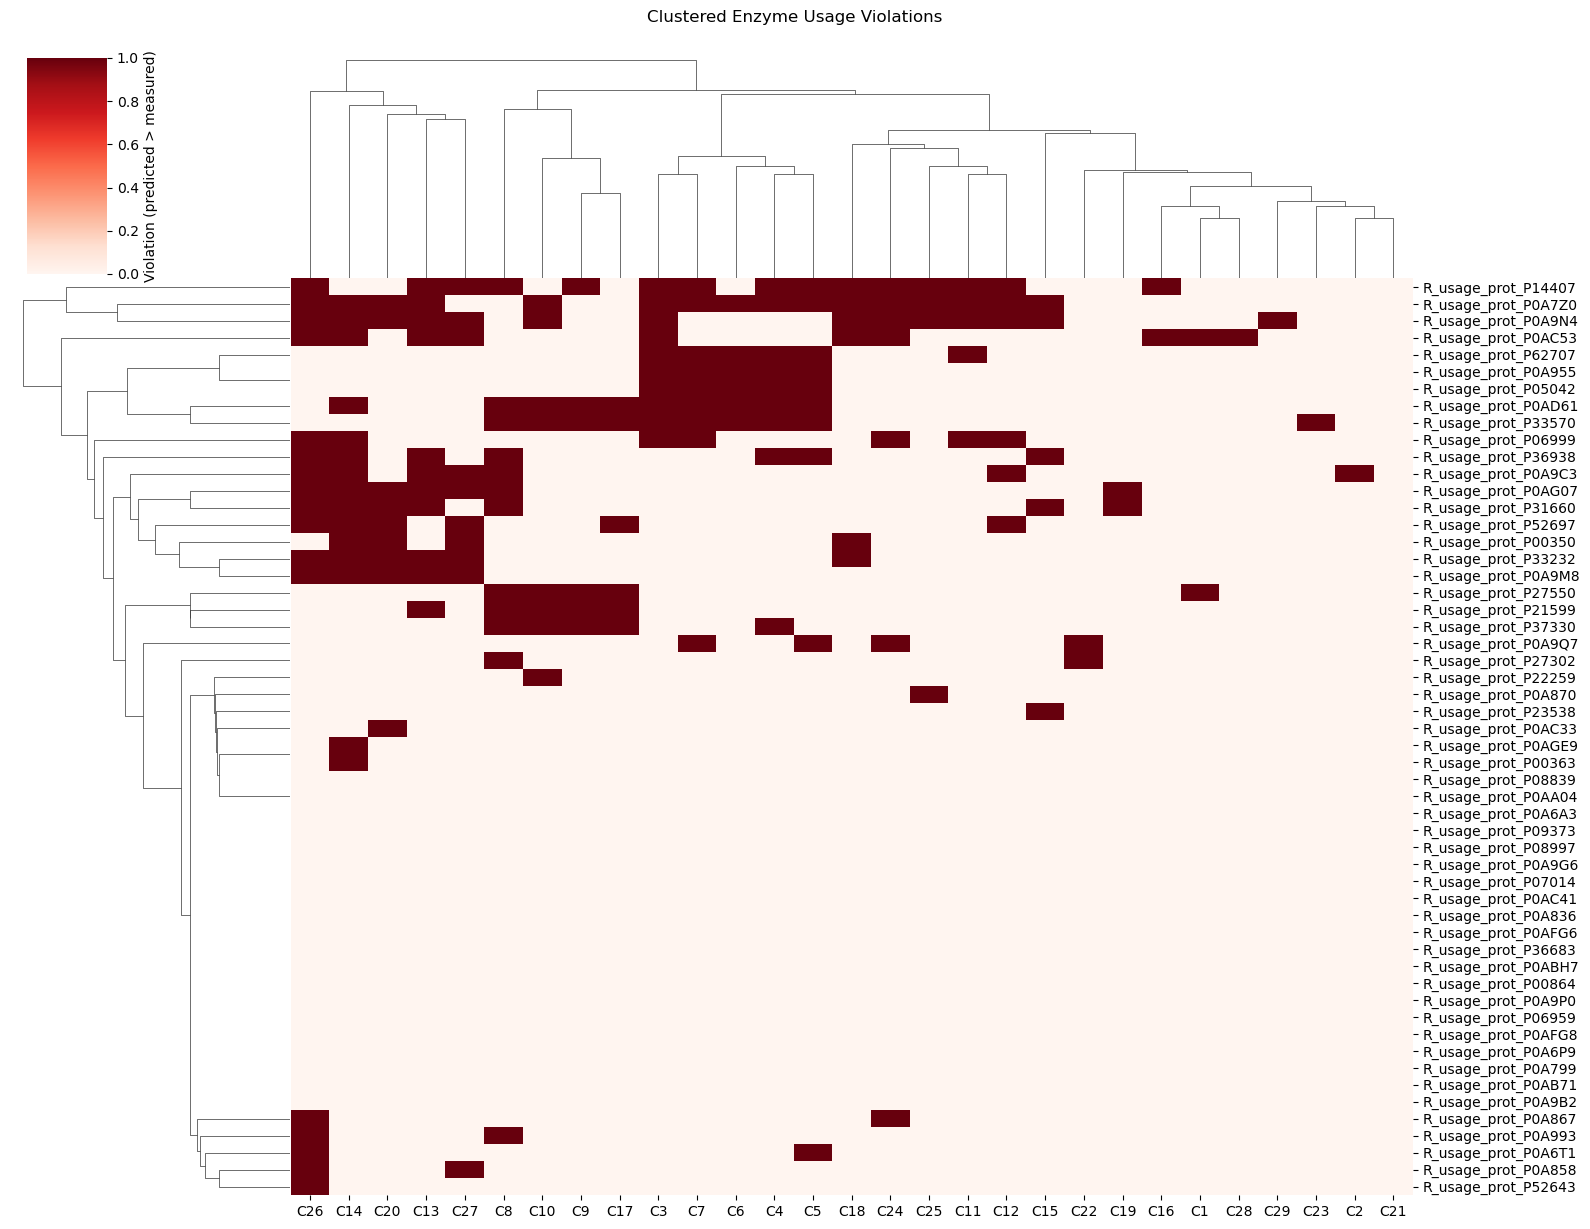

/tmp/ipykernel_1278411/4049044660.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


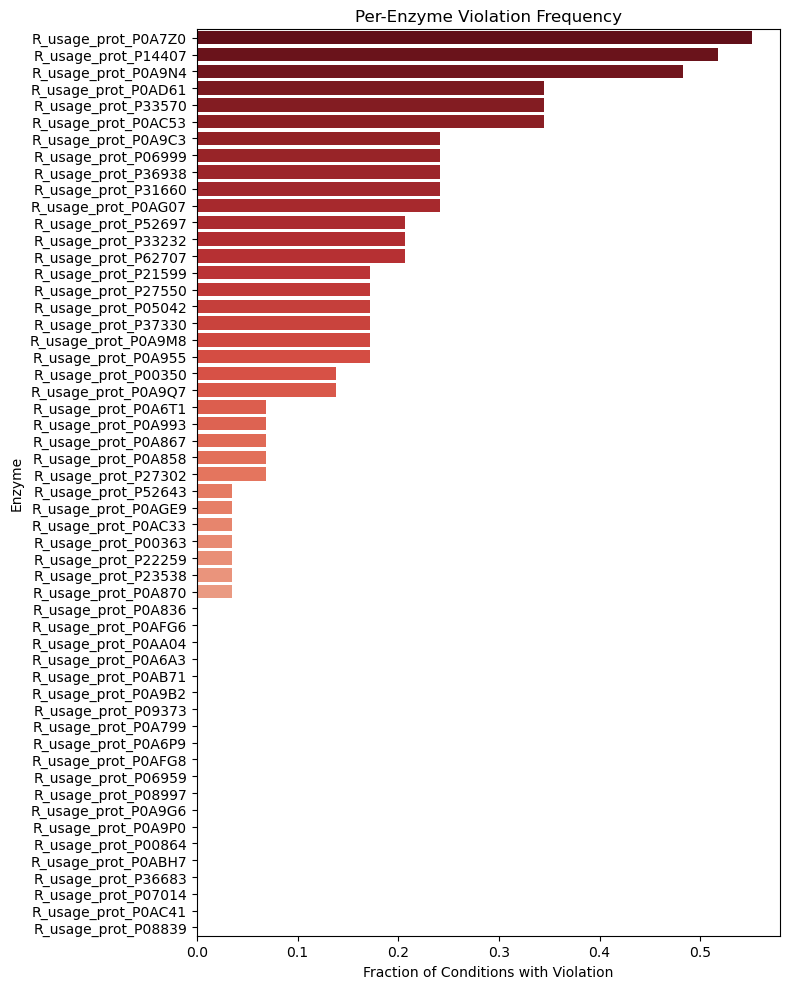

                Enzyme  FractionViolations
0  R_usage_prot_P0A7Z0            0.551724
1  R_usage_prot_P14407            0.517241
2  R_usage_prot_P0A9N4            0.482759
3  R_usage_prot_P0AD61            0.344828
4  R_usage_prot_P33570            0.344828
5  R_usage_prot_P0AC53            0.344828
6  R_usage_prot_P0A9C3            0.241379
7  R_usage_prot_P06999            0.241379
8  R_usage_prot_P36938            0.241379
9  R_usage_prot_P31660            0.241379


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Input ---
# df_pred = predicted enzyme usage (28 x 54)
# df_meas = measured proteomics (28 x 54)

# Compute violations
violations = (df_pred > df_meas).astype(int)

# ---- 1) Clustered heatmap ----
g = sns.clustermap(
    violations.T,
    cmap="Reds",
    cbar_kws={'label': 'Violation (predicted > measured)'},
    xticklabels=[f"C{i+1}" for i in range(violations.shape[0])],
    yticklabels=violations.columns,
    figsize=(16, 12)
)
plt.suptitle("Clustered Enzyme Usage Violations", y=1.02)
plt.show()

# ---- 2) Violation fraction per enzyme ----
violation_fraction = violations.sum(axis=0) / violations.shape[0]
violation_fraction_sorted = violation_fraction.sort_values(ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(
    x=violation_fraction_sorted.values,
    y=violation_fraction_sorted.index,
    palette="Reds_r"
)
plt.xlabel("Fraction of Conditions with Violation")
plt.ylabel("Enzyme")
plt.title("Per-Enzyme Violation Frequency")
plt.tight_layout()
plt.show()

# Optional: Save results as DataFrame
violation_summary = violation_fraction_sorted.reset_index()
violation_summary.columns = ["Enzyme", "FractionViolations"]
print(violation_summary.head(10))
